In [ ]:
%pip install tensorflow-hub
%pip install git+https://github.com/tensorflow/docs
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\lvcm3\AppData\Local\Temp\pip-req-build-guut5bit'
  error: RPC failed; curl 56 Recv failure: Connection was reset
  error: 8822 bytes of body are still expected
  fetch-pack: unexpected disconnect while reading sideband packet
  fatal: early EOF
  fatal: fetch-pack: invalid index-pack output
  fatal: could not fetch 3ae87b238e001dd59d042826be8ce7b3c44fbfbd from promisor remote
  You can inspect what was checked out with 'git status'
  and retry with 'git restore --source=HEAD :/'

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\lvcm3\AppData\Local\Temp\pip-req-build-guut5bit' did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet 

  Cloning https://github.com/tensorflow/docs to c:\users\lvcm3\appdata\local\temp\pip-req-build-guut5bit


In [2]:
import sys
!{sys.executable} -m pip install imageio

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import os

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [2]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (4,))
  image_from_plot = image_from_plot[:, :, :3]
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [5]:
model_name = "movenet_thunder"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [6]:
def load_movenet(image_path):
    # Load the input image.
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)
    
    return keypoints_with_scores

def visualize_movenet(keypoints_with_scores, image_path,  output_path):
    
    # Load the input image.
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    
    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

    # plt.figure(figsize=(5, 5))
    # plt.imshow(output_overlay)
    # _ = plt.axis('off')

    # Save the overlay
    cv2.imwrite(output_path, cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR))


In [7]:
def normalize_hip_center(keypoints_with_scores):
    
    # Get all keypoints
    keypoints = keypoints_with_scores[0, 0, :, :2]  # shape: (17, 2)
    scores = keypoints_with_scores[0, 0, :, 2]      # Confidence scores
    
    confidence_threshold = 0.11
    
    # Get center of body (hip)
    left_hip = keypoints[11]
    right_hip = keypoints[12]
    
    # Get the hip center (if confidence > threshold)
    if scores[11] > confidence_threshold and scores[12] > confidence_threshold :
        hip_center = (left_hip + right_hip) / 2
    elif scores[11] > confidence_threshold:
        hip_center = left_hip
    elif scores[12] > confidence_threshold:
        hip_center = right_hip
    else:
        # Fallback: use the mean of all the keypoints
        valid_indices = np.where(scores > confidence_threshold)[0]
        hip_center = np.mean(keypoints[valid_indices], axis=0) if len(valid_indices) > 0 else np.zeros(2)
    
    # Change the keypoints to hip oriented
    keypoints_centered = keypoints - hip_center
    
    # Height estimation from shoulder to hip
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    
    # Normalization with height estimation (if confidence > threshold)
    if scores[5] > confidence_threshold and scores[6] > confidence_threshold and np.linalg.norm(left_shoulder - right_shoulder) > 0:
        shoulder_center = (left_shoulder + right_shoulder) / 2
        body_height = np.linalg.norm(shoulder_center - hip_center)
        keypoints_normalized = keypoints_centered / body_height
    else:
        # Fallback: use a normal case body_height shoulder-to-hip 0.15 - 0.19
        keypoints_normalized = keypoints_centered / 0.17
    
    return keypoints_normalized


# From this, the code get started

## Visualize MoveNet

Get all 3 movement (Berdiri, Sujud, Duduk)</br>
**_<span style="color:cyan">movement = ["Berdiri", "Sujud", "Duduk"]</span>_**

Iteration per movement </br>
**_<span style="color:cyan">for j in movement:</span>_**

Get data from directory path </br>
**_<span style="color:cyan">files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]</span>_**

Iteration per data from directory </br>
**_<span style="color:cyan">for i, file in enumerate(files, start=1):</span>_**

Run MoveNet to save to image </br>
**_<span style="color:cyan">visualize_movenet(load_movenet(image_path+str(i-1)+".jpg"), image_path+str(i-1)+".jpg", final_path+str(i-1)+".jpg")</span>_**


In [ ]:
## Visualize MoveNet Raw ##

movement = ["Berdiri", "Sujud", "Duduk"]

for j in movement:
    # Set directory path
    directory_path = "Hasil/data_frame/"+j
    final_path = "Hasil/final_frame/"+j+"/final_"
    image_path = directory_path+"/frame_"

    # Get all total data in directory path
    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    # Iteration per data to movenet
    for i, file in enumerate(files, start=1):
        visualize_movenet(load_movenet(image_path+str(i-1)+".jpg"), image_path+str(i-1)+".jpg", final_path+str(i-1)+".jpg")

## Normalized Keypoints Save Fig Plot

In [ ]:
## Normalized Keypoints MoveNet Safe Plot ##

import matplotlib.pyplot as plt

movement = ["Berdiri", "Sujud", "Duduk"]

for j in range(len(movement)):
    # Set directory path
    directory_path = "Hasil/data_frame/"+movement[j]
    final_path = "Hasil/final1_frame/"+movement[j]+"/final_"
    image_path = directory_path+"/frame_"

    # Get all total data in directory path
    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    # Iteration per data
    for i, file in enumerate(files, start=1):

        # Get keypoints after normalize from data in directory path
        normalized_keypoints = normalize_hip_center(load_movenet(image_path+str(i-1)+".jpg"))

        fig = plt.figure(figsize=(5, 5), dpi=100)
        ax = fig.add_subplot(1, 1, 1)

        # Setting axis
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_title("Normalized Pose")

        # Plot titik
        for x, y in normalized_keypoints:
            plt.plot(y, x, 'ro')  # titik merah

        # Sambungkan titik-titik (opsional)
        POSE_CONNECTIONS = [
            (5, 6), (5, 11), (6, 12),  # shoulders to hips
            (5, 7), (7, 9),  # left arm
            (6, 8), (8, 10), # right arm
            (11, 13), (13, 15),  # left leg
            (12, 14), (14, 16),  # right leg
            (11, 12), (5, 6)  # hips and shoulders
        ]
        for a, b in POSE_CONNECTIONS:
            x1, y1 = normalized_keypoints[a]
            x2, y2 = normalized_keypoints[b]
            plt.plot([y1, y2], [x1, x2], 'b-')  # Blue line

        # Keep margin
        plt.tight_layout()
        plt.savefig(f"{final_path}{i-1}.jpg")
        plt.close()


## Normalized Keypoints to CSV

Set Dictionary of keypoint</br>

Set header of CSV</br>
**<span style="color:cyan">
header = [] </br>
for j in range(len(KEYPOINT_DICT)):</br>
    header += [next(k for k, v in KEYPOINT_DICT.items() if v == j)+"_y"]</br>
    header += [next(k for k, v in KEYPOINT_DICT.items() if v == j)+"_x"]</br>
</span>**

Open CSV file</br>
**_<span style="color:cyan">with open(file_output, mode='w', newline='') as file:</span>_**

Get flatten keypoints normalize</br>
**_<span style="color:cyan">normalized_keypoints = normalize_hip_center(load_movenet(image_path+str(i-1)+".jpg")).flatten()</span>_**

Write header & data</br>
**_<span style="color:cyan">writer.writerow([h.ljust(column_width) for h in header])</span>_**</br>
**_<span style="color:cyan">writer.writerow([h.ljust(column_width) for h in result])</span>_**

In [ ]:
## Save Normalized Keypoints to CSV ##

import csv

movement = ["Berdiri", "Duduk", "Sujud"]

KEYPOINT_DICT = {
    'nose': 0,
    'l_eye': 1,
    'r_eye': 2,
    'l_ear': 3,
    'r_ear': 4,
    'l_shldr': 5,
    'r_shldr': 6,
    'l_elbow': 7,
    'r_elbow': 8,
    'l_wrist': 9,
    'r_wrist': 10,
    'l_hip': 11,
    'r_hip': 12,
    'l_knee': 13,
    'r_knee': 14,
    'l_ankle': 15,
    'r_ankle': 16
}

for m in movement:

    # Set directory path
    directory_path = "Hasil/data_frame/"+m
    image_path = directory_path+"/frame_"

    # Get all data from directory path
    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    # Set header for CSV file
    header = []

    for j in range(len(KEYPOINT_DICT)):
        header += [next(k for k, v in KEYPOINT_DICT.items() if v == j)+"_y"]
        header += [next(k for k, v in KEYPOINT_DICT.items() if v == j)+"_x"]

    file_output = "Hasil/keypoints_"+m+".csv"

    # Fix width col
    column_width = 12

    # Open CSV file
    with open(file_output, mode='w', newline='') as file:

        writer = csv.writer(file)

        # Write CSV file header
        writer.writerow([h.ljust(column_width) for h in header])

        # Iteration per data in directory path
        for i, file in enumerate(files, start=1):

            # Get flatten normalize keypoints
            normalized_keypoints = normalize_hip_center(load_movenet(image_path+str(i-1)+".jpg")).flatten()
            result = [f"{num:.9f}" for num in normalized_keypoints]

            # Write CSV file data
            writer.writerow([h.ljust(column_width) for h in result])

## Keypoints for Person to CSV

In [15]:
## Save Normalized Keypoints to CSV ##

import csv

movement = ["Berdiri", "Duduk", "Sujud"]
person = ["Galileo", "Hizkia", "Nicholas", "Ridwan", "Adji", "Bill", "Khanif"]
val = ["Galileo", "Adji"]

KEYPOINT_DICT = {
    'nose': 0,
    'l_eye': 1,
    'r_eye': 2,
    'l_ear': 3,
    'r_ear': 4,
    'l_shldr': 5,
    'r_shldr': 6,
    'l_elbow': 7,
    'r_elbow': 8,
    'l_wrist': 9,
    'r_wrist': 10,
    'l_hip': 11,
    'r_hip': 12,
    'l_knee': 13,
    'r_knee': 14,
    'l_ankle': 15,
    'r_ankle': 16
}

# Set header for CSV file
header = []

for j in range(len(KEYPOINT_DICT)):
    header += [next(k for k, v in KEYPOINT_DICT.items() if v == j)+"_y"]
    header += [next(k for k, v in KEYPOINT_DICT.items() if v == j)+"_x"]
header += ["label"]

# Fix width col
column_width = 12

file_train = "Hasil/keypoints_train.csv"
file_val = "Hasil/keypoints_val.csv"

# Open CSV file
with open(file_train, mode='w', newline='') as file:
    with open(file_val, mode='w', newline='') as fileVal:

        writer1 = csv.writer(fileVal)
        writer = csv.writer(file)

        # Write CSV file header
        writer.writerow([h.ljust(column_width) for h in header])
        writer1.writerow([h.ljust(column_width) for h in header])

        writerTemp = writer

        for p in person:

            if p in val:
                writerTemp = writer1
            else:
                writerTemp = writer

            for m in movement:

                # Set directory path
                directory_path = p+"/Hasil/data_frame/"+m
                image_path = directory_path+"/frame_"

                # Get all data from directory path
                files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

                # Iteration per data in directory path
                for i, file in enumerate(files, start=1):

                    # Get flatten normalize keypoints
                    normalized_keypoints = normalize_hip_center(load_movenet(image_path+str(i-1)+".jpg")).flatten()
                    result = [f"{num:.9f}" for num in normalized_keypoints]
                    result += [m]

                    # Write CSV file data
                    writerTemp.writerow([h.ljust(column_width) for h in result])

## Join All Keypoints

In [11]:
## Join Keypoints to Final Result

import csv

movement = ["Berdiri", "Duduk", "Sujud"]

KEYPOINT_DICT = {
    'nose': 0,
    'l_eye': 1,
    'r_eye': 2,
    'l_ear': 3,
    'r_ear': 4,
    'l_shldr': 5,
    'r_shldr': 6,
    'l_elbow': 7,
    'r_elbow': 8,
    'l_wrist': 9,
    'r_wrist': 10,
    'l_hip': 11,
    'r_hip': 12,
    'l_knee': 13,
    'r_knee': 14,
    'l_ankle': 15,
    'r_ankle': 16
}

final = "Hasil/keypoints.csv"

with open(final, mode='w', newline='') as file :

    header_bool = False
    write_csv = csv.writer(file)

    for i in range(len(movement)):

        keypoints = "Hasil/keypoints_"+movement[i]+".csv"

        with open(keypoints, mode='r', newline='') as file:
            reader = csv.reader(file)
            header = next(reader)
            header += ["label"]
            if(not(header_bool)):
                write_csv.writerow(header)
                header_bool = True

            for row in reader:
                row = [float(rows) for rows in row]
                row += [movement[i]]
                write_csv.writerow(row)


## Check for Coordinate Real Image vs Augmented Image (Vertically Mirroring)

#### Difference between real image & augmented (vertically mirroring) x & x' totally different

In [24]:
## Check Difference Between Real Image & Augmented ##

KEYPOINT_DICT = {
    'nose': 0,
    'l_eye': 1,
    'r_eye': 2,
    'l_ear': 3,
    'r_ear': 4,
    'l_shldr': 5,
    'r_shldr': 6,
    'l_elbow': 7,
    'r_elbow': 8,
    'l_wrist': 9,
    'r_wrist': 10,
    'l_hip': 11,
    'r_hip': 12,
    'l_knee': 13,
    'r_knee': 14,
    'l_ankle': 15,
    'r_ankle': 16
}

# Set header to output
header = []

# Fix width col
column_width = 12

for j in range(0, 17):
    header += [next(k for k, v in KEYPOINT_DICT.items() if v == j)+"_y"]
    header += [next(k for k, v in KEYPOINT_DICT.items() if v == j)+"_x"]

print([h.ljust(column_width) for h in header])

## Value Check ##
gerakan = "Sujud"
frame = 557

# Set directory path
directory_path = "Hasil/data_frame/"+gerakan
image_path = directory_path+"/frame_"

# Get all data from directory path and total/2
files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
total_file = int(len(files)/2)

# Image1 normal image get keypoints normalize
image_path = "Hasil/data_frame/"+gerakan+"/frame_"+str(frame)+".jpg"
normalized_keypoints = normalize_hip_center(load_movenet(image_path)).flatten()
hasil = [f"{num:.9f}" for num in normalized_keypoints]

print([str(frame)]+[h.ljust(column_width) for h in hasil])

# Image2 augmented image get keypoints normalize
image_path = "Hasil/data_frame/Duduk/frame_"+str(frame+total_file)+".jpg"
normalized_keypoints = normalize_hip_center(load_movenet(image_path)).flatten()
hasil = [f"{num:.9f}" for num in normalized_keypoints]
print([str(frame+total_file)]+[h.ljust(column_width) for h in hasil])



['nose_y      ', 'nose_x      ', 'l_eye_y     ', 'l_eye_x     ', 'r_eye_y     ', 'r_eye_x     ', 'l_ear_y     ', 'l_ear_x     ', 'r_ear_y     ', 'r_ear_x     ', 'l_shldr_y   ', 'l_shldr_x   ', 'r_shldr_y   ', 'r_shldr_x   ', 'l_elbow_y   ', 'l_elbow_x   ', 'r_elbow_y   ', 'r_elbow_x   ', 'l_wrist_y   ', 'l_wrist_x   ', 'r_wrist_y   ', 'r_wrist_x   ', 'l_hip_y     ', 'l_hip_x     ', 'r_hip_y     ', 'r_hip_x     ', 'l_knee_y    ', 'l_knee_x    ', 'r_knee_y    ', 'r_knee_x    ', 'l_ankle_y   ', 'l_ankle_x   ', 'r_ankle_y   ', 'r_ankle_x   ']
['557', '1.318346381 ', '-0.571944416', '1.377509236 ', '-0.605420411', '1.368300319 ', '-0.624004602', '1.280033827 ', '-0.621252596', '1.239267945 ', '-0.710023165', '0.889830530 ', '-0.508243859', '0.765324533 ', '-0.614459693', '0.883359194 ', '0.199855059 ', '0.841187477 ', '-0.239032492', '1.301983953 ', '0.123639010 ', '1.257931828 ', '0.102156200 ', '0.034755234 ', '-0.023501195', '-0.034755550', '0.023501195 ', '0.834784269 ', '0.198331967 ',

[[ 0.71756077  0.968059  ]
 [ 0.8482476   0.99223155]
 [ 0.9050916   1.135846  ]
 [ 0.606267    1.1209421 ]
 [ 0.6210234   1.5625191 ]
 [-0.7001495   0.53740925]
 [-0.335894    1.1733255 ]
 [-0.74615765 -1.7703601 ]
 [-0.03977473  1.1125004 ]
 [ 0.8208825  -1.3322232 ]
 [ 0.2644343   1.7198913 ]
 [-1.975069   -0.01121307]
 [-1.8268708   0.17614509]
 [-0.80221087 -1.7228596 ]
 [-0.4721225  -0.6977344 ]
 [ 0.7342737  -1.3421639 ]
 [-2.4612463  -2.3448904 ]]


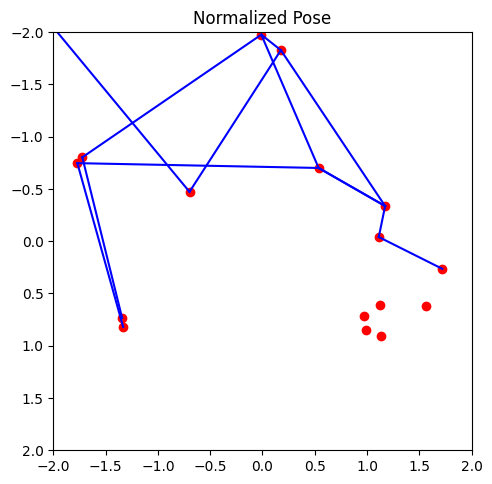

In [28]:
image_path = "Hasil/data_frame/Sujud/frame_1343.jpg"
normalized_keypoints = normalize_hip_center(load_movenet(image_path))

print(normalized_keypoints)

fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Setting axis
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_title("Normalized Pose")

# Plot titik
for x, y in normalized_keypoints:
    plt.plot(y, x, 'ro')  # titik merah

# Sambungkan titik-titik (opsional)
POSE_CONNECTIONS = [
    (5, 6), (5, 11), (6, 12),  # shoulders to hips
    (5, 7), (7, 9),  # left arm
    (6, 8), (8, 10), # right arm
    (11, 13), (13, 15),  # left leg
    (12, 14), (14, 16),  # right leg
    (11, 12), (5, 6)  # hips and shoulders
]
for a, b in POSE_CONNECTIONS:
    x1, y1 = normalized_keypoints[a]
    x2, y2 = normalized_keypoints[b]
    plt.plot([y1, y2], [x1, x2], 'b-')  # garis biru

# Jaga margin tetap
plt.tight_layout()
plt.show()
plt.close()


In [27]:
## Check Keypoints & Conf. Score from Data ##

# Set directory path
image_path = "Hasil/data_frame/Duduk/frame_1343.jpg"

# Load the input image.
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
keypoints_with_scores = movenet(input_image)
# keypoints_with_scores = normalize_hip_center(load_movenet(input_image))

# List name of 17 keypoints movenet
keypoint_names = [
    "Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear",
    "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow",
    "Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"
]

# Get all keypoints
keypoints = keypoints_with_scores[0, 0]  # shape (17, 3)
print(keypoints_with_scores[0][0][11])

# Threshold confidence
threshold = 0.3

# Iteration per keypoints print coordinate & conf. score
for i, (y, x, score) in enumerate(keypoints):
    name = keypoint_names[i]
    status = "✓" if score > threshold else "✗"
    print(f"{name:<15}: x={x:.3f}, y={y:.3f}, score={score:.3f} {status}")

[0.71722597 0.45903614 0.5398249 ]
Nose           : x=0.479, y=0.573, score=0.622 ✓
Left Eye       : x=0.491, y=0.559, score=0.640 ✓
Right Eye      : x=0.468, y=0.559, score=0.532 ✓
Left Ear       : x=0.490, y=0.548, score=0.359 ✓
Right Ear      : x=0.432, y=0.543, score=0.720 ✓
Left Shoulder  : x=0.488, y=0.583, score=0.561 ✓
Right Shoulder : x=0.392, y=0.596, score=0.432 ✓
Left Elbow     : x=0.510, y=0.680, score=0.353 ✓
Right Elbow    : x=0.396, y=0.713, score=0.330 ✓
Left Wrist     : x=0.553, y=0.764, score=0.389 ✓
Right Wrist    : x=0.442, y=0.802, score=0.559 ✓
Left Hip       : x=0.459, y=0.717, score=0.540 ✓
Right Hip      : x=0.382, y=0.738, score=0.635 ✓
Left Knee      : x=0.556, y=0.816, score=0.571 ✓
Right Knee     : x=0.445, y=0.806, score=0.270 ✗
Left Ankle     : x=0.451, y=0.808, score=0.136 ✗
Right Ankle    : x=0.446, y=0.827, score=0.138 ✗
